In [ ]:
# to create a Conda environment that can be used to run the package
# conda create -n r_test -y r-essentials r-devtools

# to install the rwwa package
devtools::install_github("clairbarnes/rwwa")

---
To bring up the documentation for a command, type ?command: eg. `?fit_ns`

---
# Load data

In [3]:
# load package containing functions
library(rwwa)

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




In [46]:
# load data
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino_ann <- read.csv("nino34_ann.csv", col.names = c("year", "nino"))

hi <- read.csv("hi5day.csv", col.names = c("year", "hi"))

# compile into a single dataframe (will match on any common columns by default - in this case, 'year')
df <- merge(merge(gmst, nino_ann), hi)

# create dataframe of covariates to be used later
cov_2023 <- df[df$year == 2023, c("gmst", "nino")]
cov_cf <- rbind("pi" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023[,"gmst"], 0))

# Fit nonstationary model


In [4]:
mdl_gmst <- fit_ns("gev", "shift", data = df, varnm = "hi", covnm = c("gmst"), lower = F)             # trend depends only on GMST
mdl_nino <- fit_ns("gev", "shift", data = df, varnm = "hi", covnm = c("gmst", "nino"), lower = F)     # trend depends on both GMST and Nino

In [5]:
# which gives the best overall fit? (lower AIC is better)
cat("GMST only     ",aic(mdl_gmst),"\n")
cat("GMST + Nino34 ",aic(mdl_nino),"\n")

GMST only      266.8832 
GMST + Nino34  257.7762 


## Compare the fitted trends

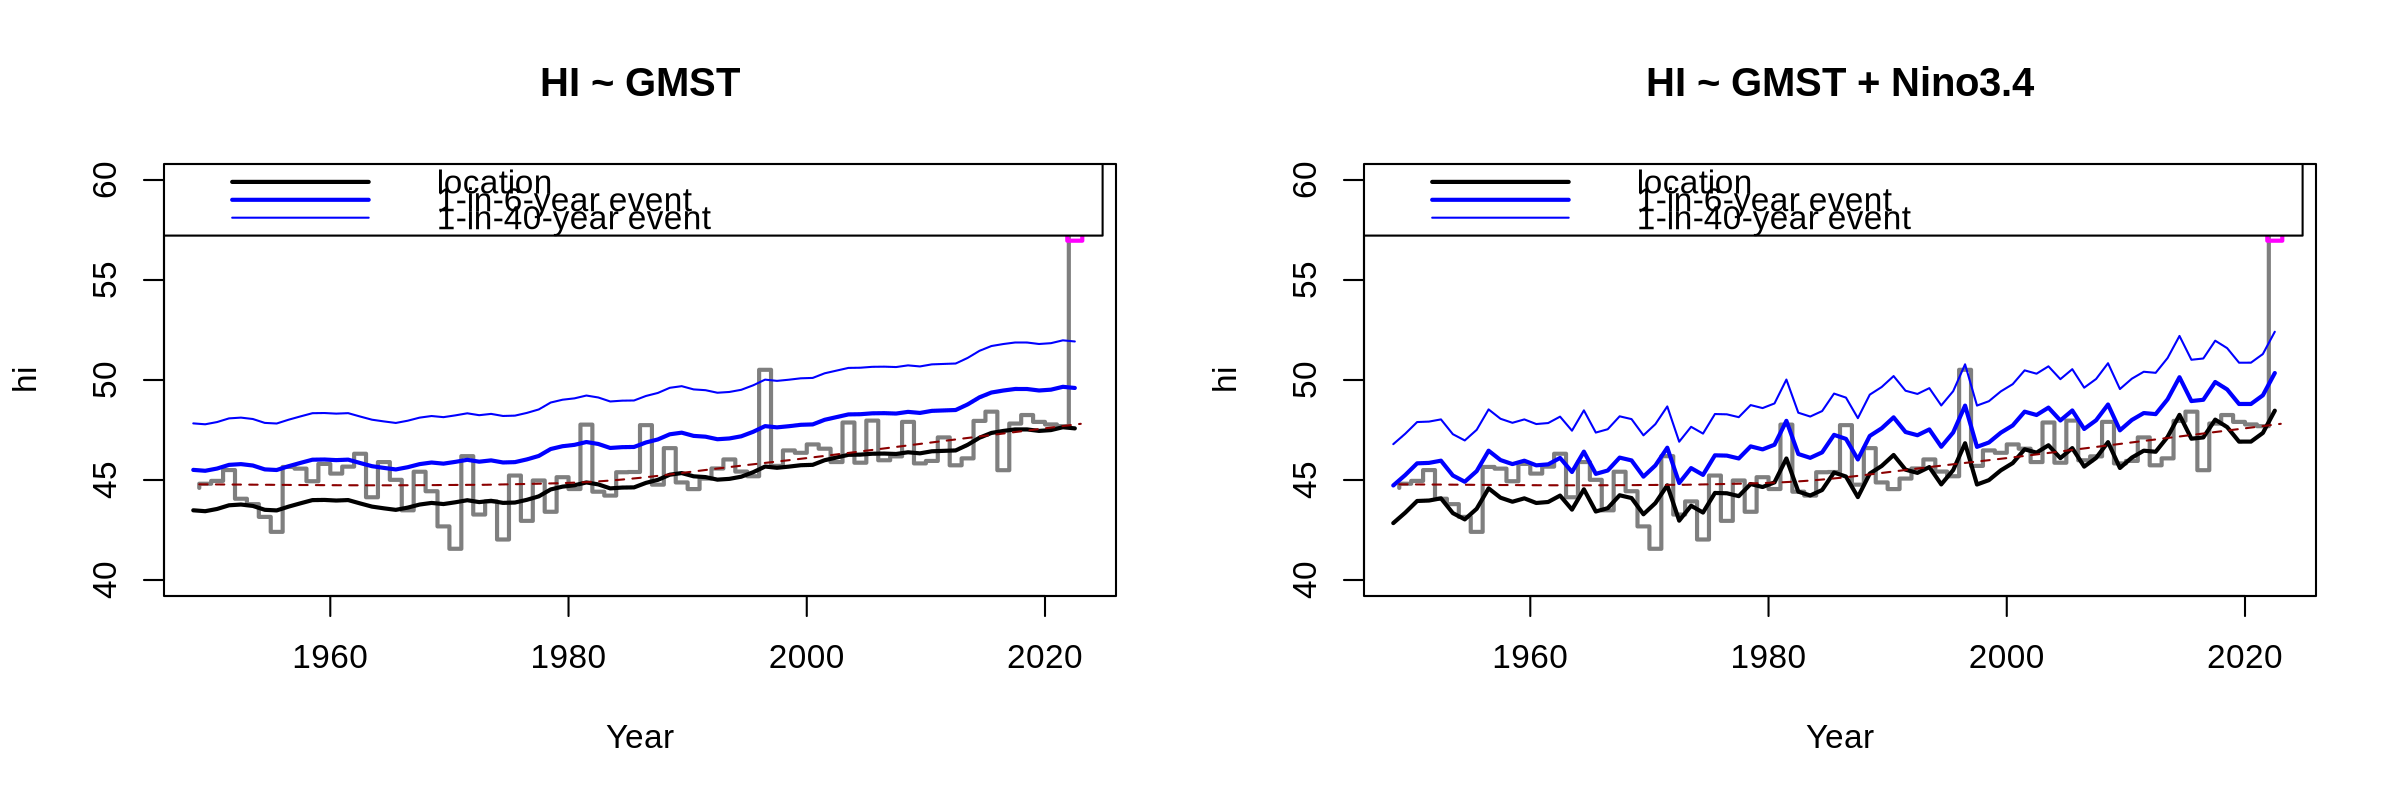

In [6]:
# prep_window sets the size of the plotting area & number of rows & columns to plot
prep_window(c(1,2), h = 4, w = 6)

# GMST trend vs simple lowess smoother
plot_trend(mdl_gmst, main = "HI ~ GMST")
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

plot_trend(mdl_nino, main = "HI ~ GMST + Nino3.4")
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

## Visualise the chosen model

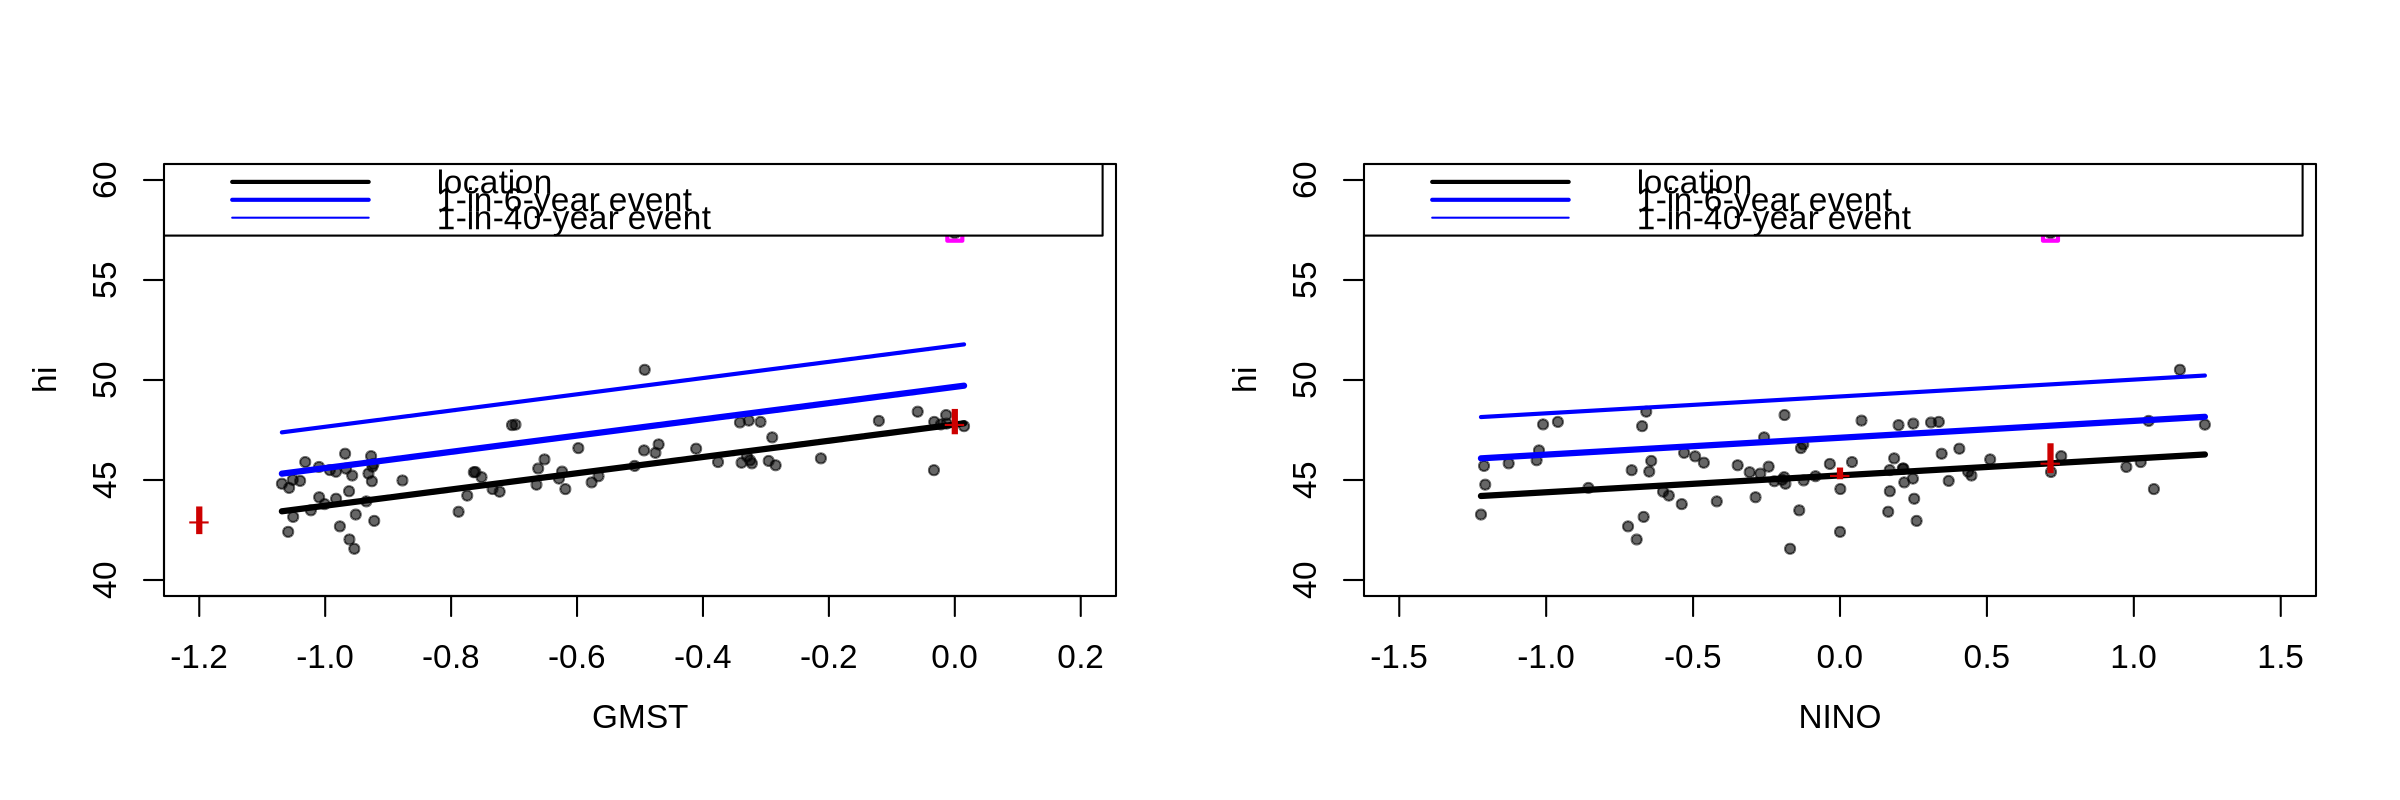

In [14]:
# plot trends against covariates, rather than against time
prep_window(c(1,2), h = 4, w = 6)

plot_covtrend(mdl_nino, xcov = "gmst", nsamp = 100, 
              ci_cov = data.frame(gmst = c(0,-1.2), nino = mean(df$nino)),
              plot_cov = data.frame(gmst = df$gmst, nino = mean(df$nino)))

plot_covtrend(mdl_nino, xcov = "nino", nsamp = 100, 
              ci_cov = data.frame(gmst = mean(df$gmst), nino = c(df$nino[df$year == 2023], 0)),
              plot_cov = data.frame(gmst = mean(df$gmst), nino = df$nino))

## Diagnostic plots of residuals

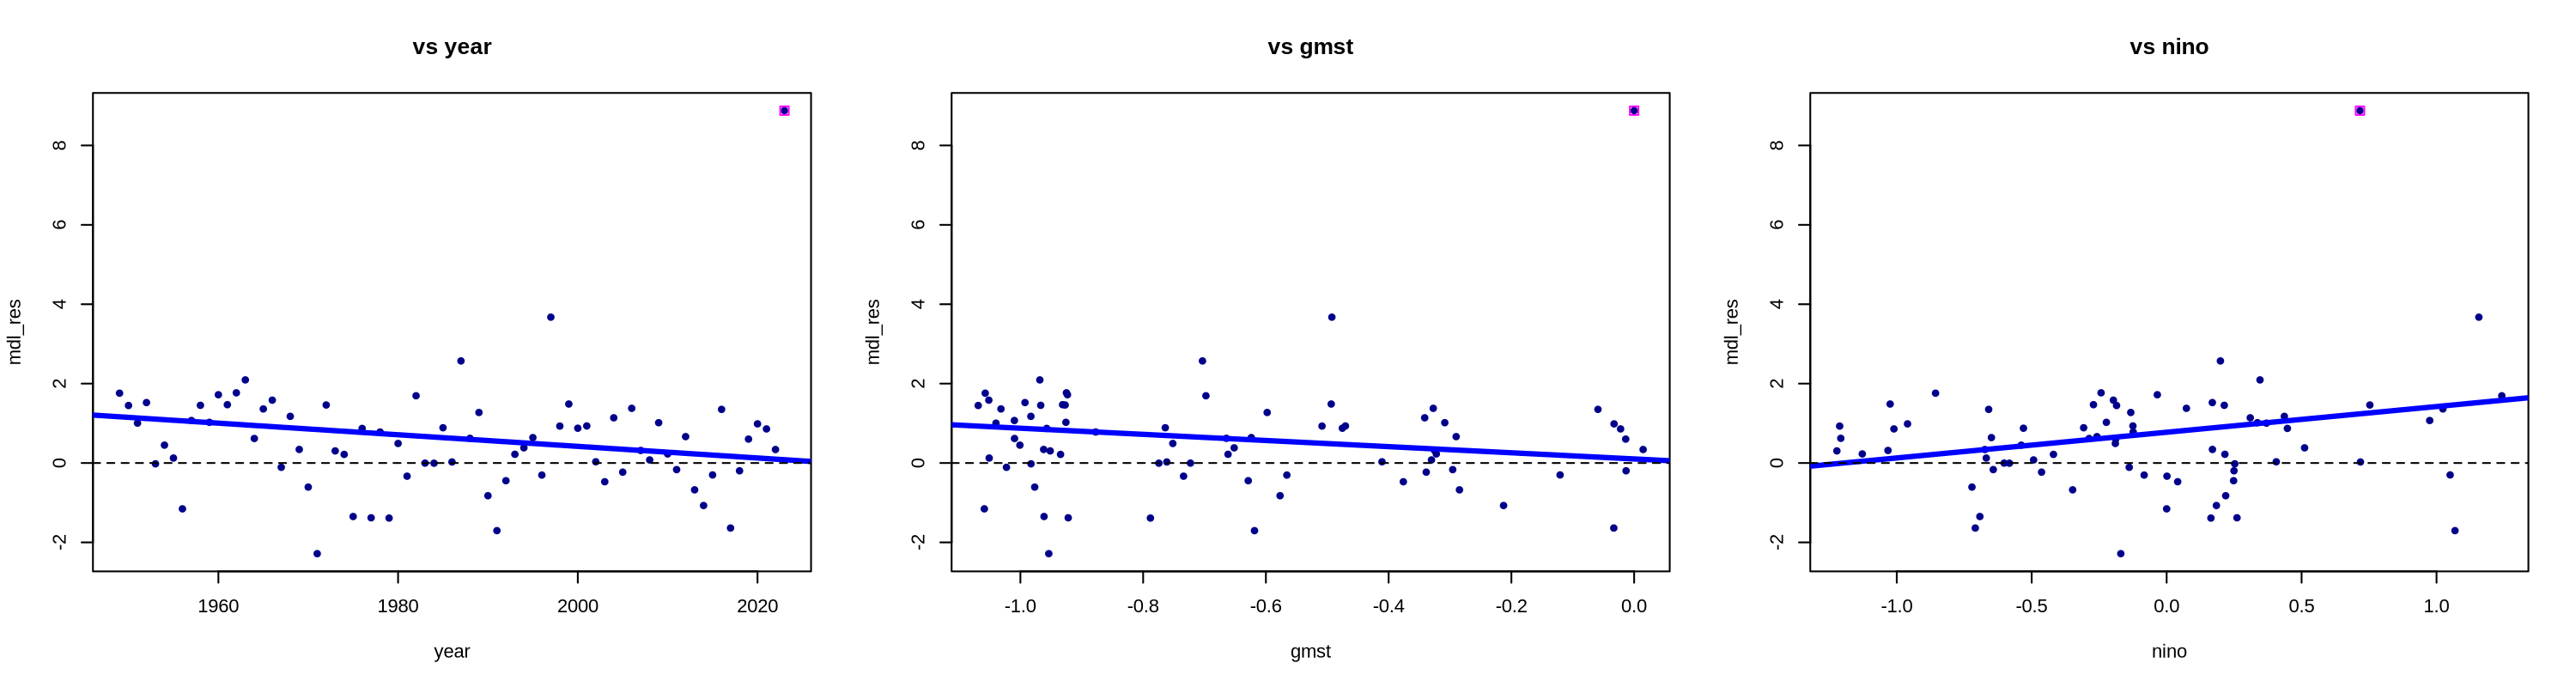

In [34]:
# any trend in residuals from fitted model?
mdl_res <- df$hi - ns_pars(mdl_nino)$loc

prep_window(c(1,3), h = 4, w = 5)

for (x in c("year", "gmst", "nino")) {
    plot(df[,x], mdl_res, main = paste0("vs ",x), col = "darkblue", pch = 20, xlab = x)
    points(df[df$year == 2023,x], mdl_res[df$year == 2023], col = "magenta", pch = 0)
    abline(line(df[,x], mdl_res), lwd = 3, col = "blue")                  # quick fitted least-squares line - could also
    abline(h = 0, lty = 2)
}

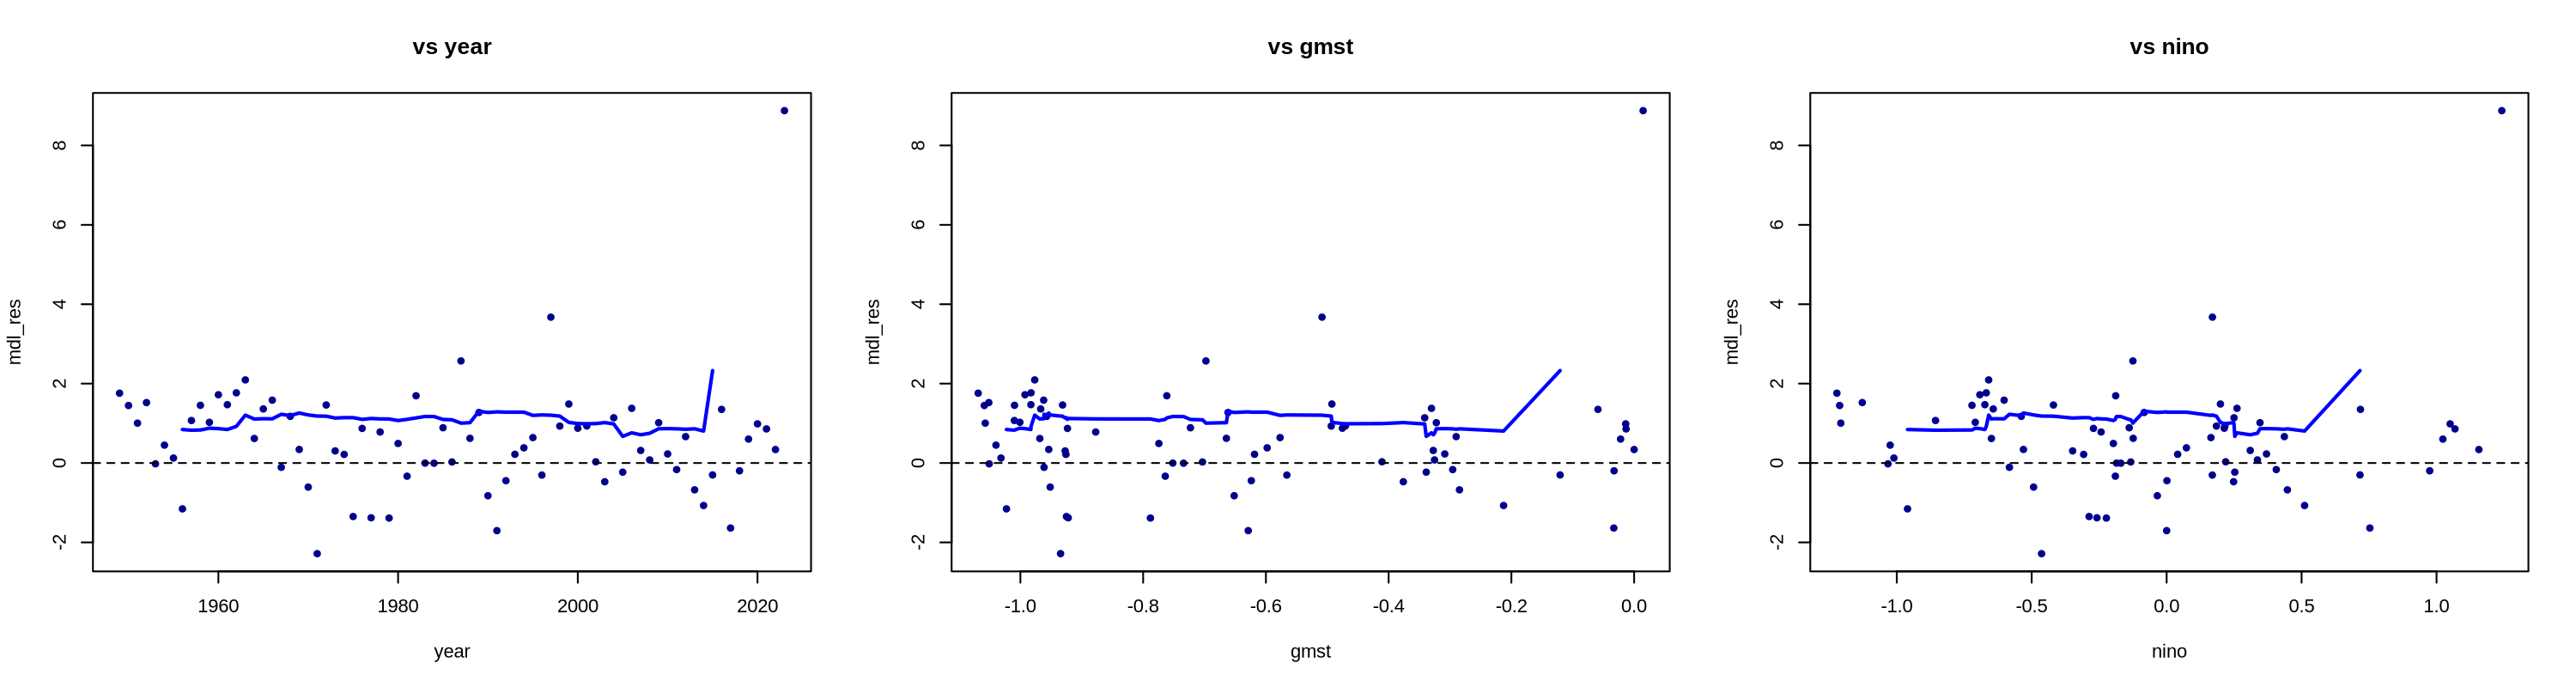

In [40]:
# standard deviation of the residuals - pretty flat either way
prep_window(c(1,3), h = 4, w = 5)

for (x in c("year", "gmst", "nino")) {
    
    # reorder data - easier to get rolling mean that way
    df <- df[order(df[,x]),]
    plot(df[,x], mdl_res, main = paste0("vs ",x), col = "darkblue", pch = 20, xlab = x)
    
    # 15-point rolling mean
    lines(df[8:(nrow(df)-8),x], sapply(1:(nrow(df)-15), function(ys) { sd(mdl_res[ys+(0:15)]) }), type = "l", lwd = 2, col = "blue")
    abline(h = 0, lty = 2)
}

# restore data to correct order
df <- df[order(df$year),]

## Return level plot

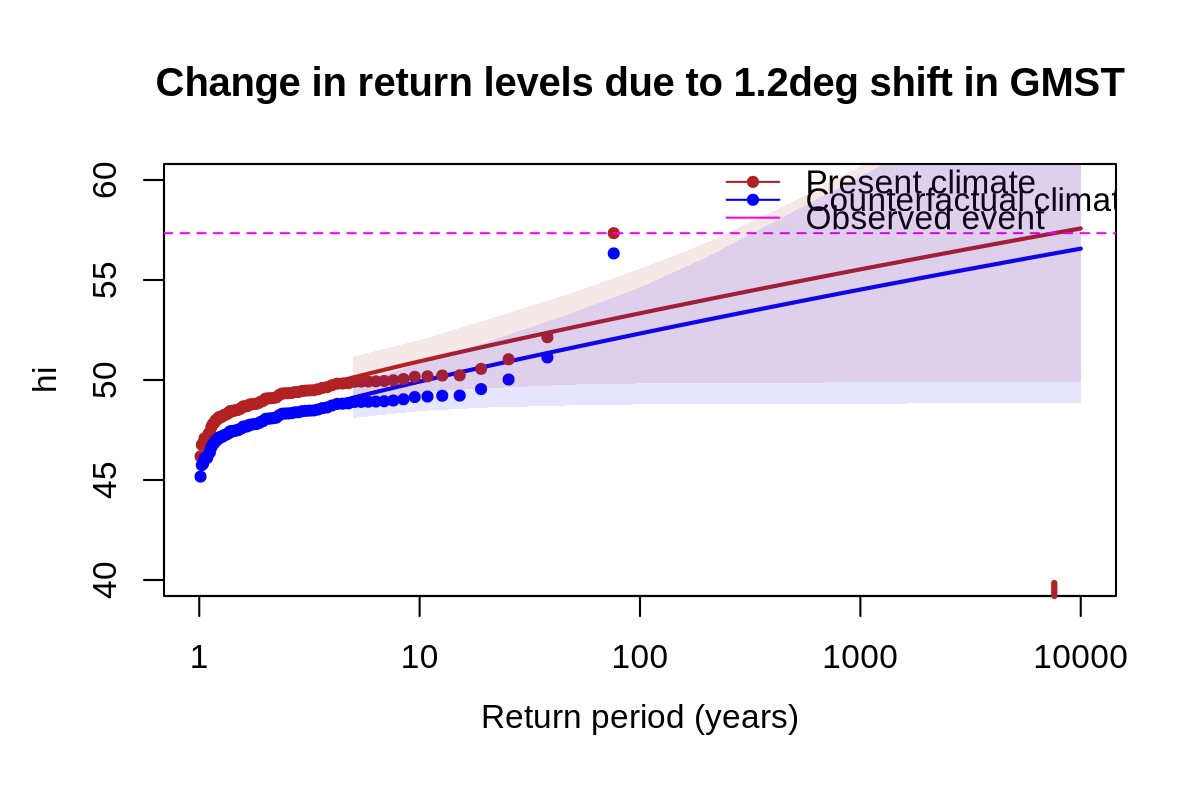

In [43]:
prep_window(c(1,1), h = 4, w = 6)
plot_returnlevels(mdl_nino, cov_f = df[df$year == 2023,], cov_cf = df[df$year == 2023,] - c(1.2, 0), 
                  main = "Change in return levels due to 1.2deg shift in GMST", nsamp = 1000)

## Bootstrapped parameter estimates

In [51]:
res <- boot_ci(mdl_nino, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000)
res

,est,2.5%,97.5%
mu0,47.86077203,47.2674295,4.859606e+01
sigma0,1.13481287,0.8538561,1.324786e+00
alpha_gmst,4.06019249,3.0214869,4.980565e+00
alpha_nino,0.84274207,0.3393532,1.778313e+00
shape,-0.03045128,-0.6859274,1.387037e-01
disp,0.02341534,0.0177220,2.709878e-02
event_magnitude,57.34069824,57.3406982,5.734070e+01
return_period,7584.85735247,249.7376772,Inf
PR_pi,484.38174769,5.0260708,5.506272e+04
dI_abs_pi,4.87223099,3.7740170,6.031726e+00
